<a href="https://colab.research.google.com/github/vs21542/CE888_DSDM/blob/main/code/Coupon_Recommendation_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns_raw
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV, cross_val_predict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.utils import shuffle

In [ ]:
df_raw = pd.read_csv("in-vehicle-coupon-recommendation.csv")
df_raw.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

In [ ]:
df_raw.dtypes

destination             object
passanger               object
weather                 object
temperature              int64
time                    object
coupon                  object
expiration              object
gender                  object
age                     object
maritalStatus           object
has_children             int64
education               object
occupation              object
income                  object
car                     object
Bar                     object
CoffeeHouse             object
CarryAway               object
RestaurantLessThan20    object
Restaurant20To50        object
toCoupon_GEQ5min         int64
toCoupon_GEQ15min        int64
toCoupon_GEQ25min        int64
direction_same           int64
direction_opp            int64
Y                        int64
dtype: object

In [ ]:
df_raw.shape

(12684, 26)

In [ ]:
df_raw.isna().sum()

destination                 0
passanger                   0
weather                     0
temperature                 0
time                        0
coupon                      0
expiration                  0
gender                      0
age                         0
maritalStatus               0
has_children                0
education                   0
occupation                  0
income                      0
car                     12576
Bar                       107
CoffeeHouse               217
CarryAway                 151
RestaurantLessThan20      130
Restaurant20To50          189
toCoupon_GEQ5min            0
toCoupon_GEQ15min           0
toCoupon_GEQ25min           0
direction_same              0
direction_opp               0
Y                           0
dtype: int64

In [ ]:
# Check pecertange of missing values present in each of the features.
((df_raw.isna().sum())/(len(df_raw)))*100

destination              0.000000
passanger                0.000000
weather                  0.000000
temperature              0.000000
time                     0.000000
coupon                   0.000000
expiration               0.000000
gender                   0.000000
age                      0.000000
maritalStatus            0.000000
has_children             0.000000
education                0.000000
occupation               0.000000
income                   0.000000
car                     99.148534
Bar                      0.843582
CoffeeHouse              1.710817
CarryAway                1.190476
RestaurantLessThan20     1.024913
Restaurant20To50         1.490066
toCoupon_GEQ5min         0.000000
toCoupon_GEQ15min        0.000000
toCoupon_GEQ25min        0.000000
direction_same           0.000000
direction_opp            0.000000
Y                        0.000000
dtype: float64

In [ ]:
# If target variable 'Y' is evenly distributed between 0 and 1, then it is a balanced dataset.
df_raw['Y'].value_counts()

1    7210
0    5474
Name: Y, dtype: int64

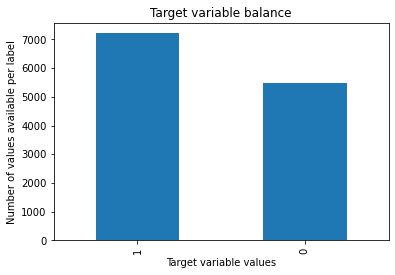

In [ ]:
#Analyzing the is target variable balance or not?
df_raw['Y'].value_counts().plot(kind='bar')

plt.title('Target variable balance')
plt.xlabel('Target variable values')
plt.ylabel('Number of values available per label')

plt.show()

*It is a balanced dataset because around 57% values present as 1 and 43% values are present as 0 in target variable 'Y'.*

In [ ]:
# Preprocessing step: Dropping 'Car' column since 99% of values present are null.
df_raw = df_raw.drop(['car'], axis = 1)

In [ ]:
# Preprocessing step: Dropping 'toCoupon_GEQ5min' column since it containing all redundent values as 1. 
df_raw = df_raw.drop('toCoupon_GEQ5min', axis=1)

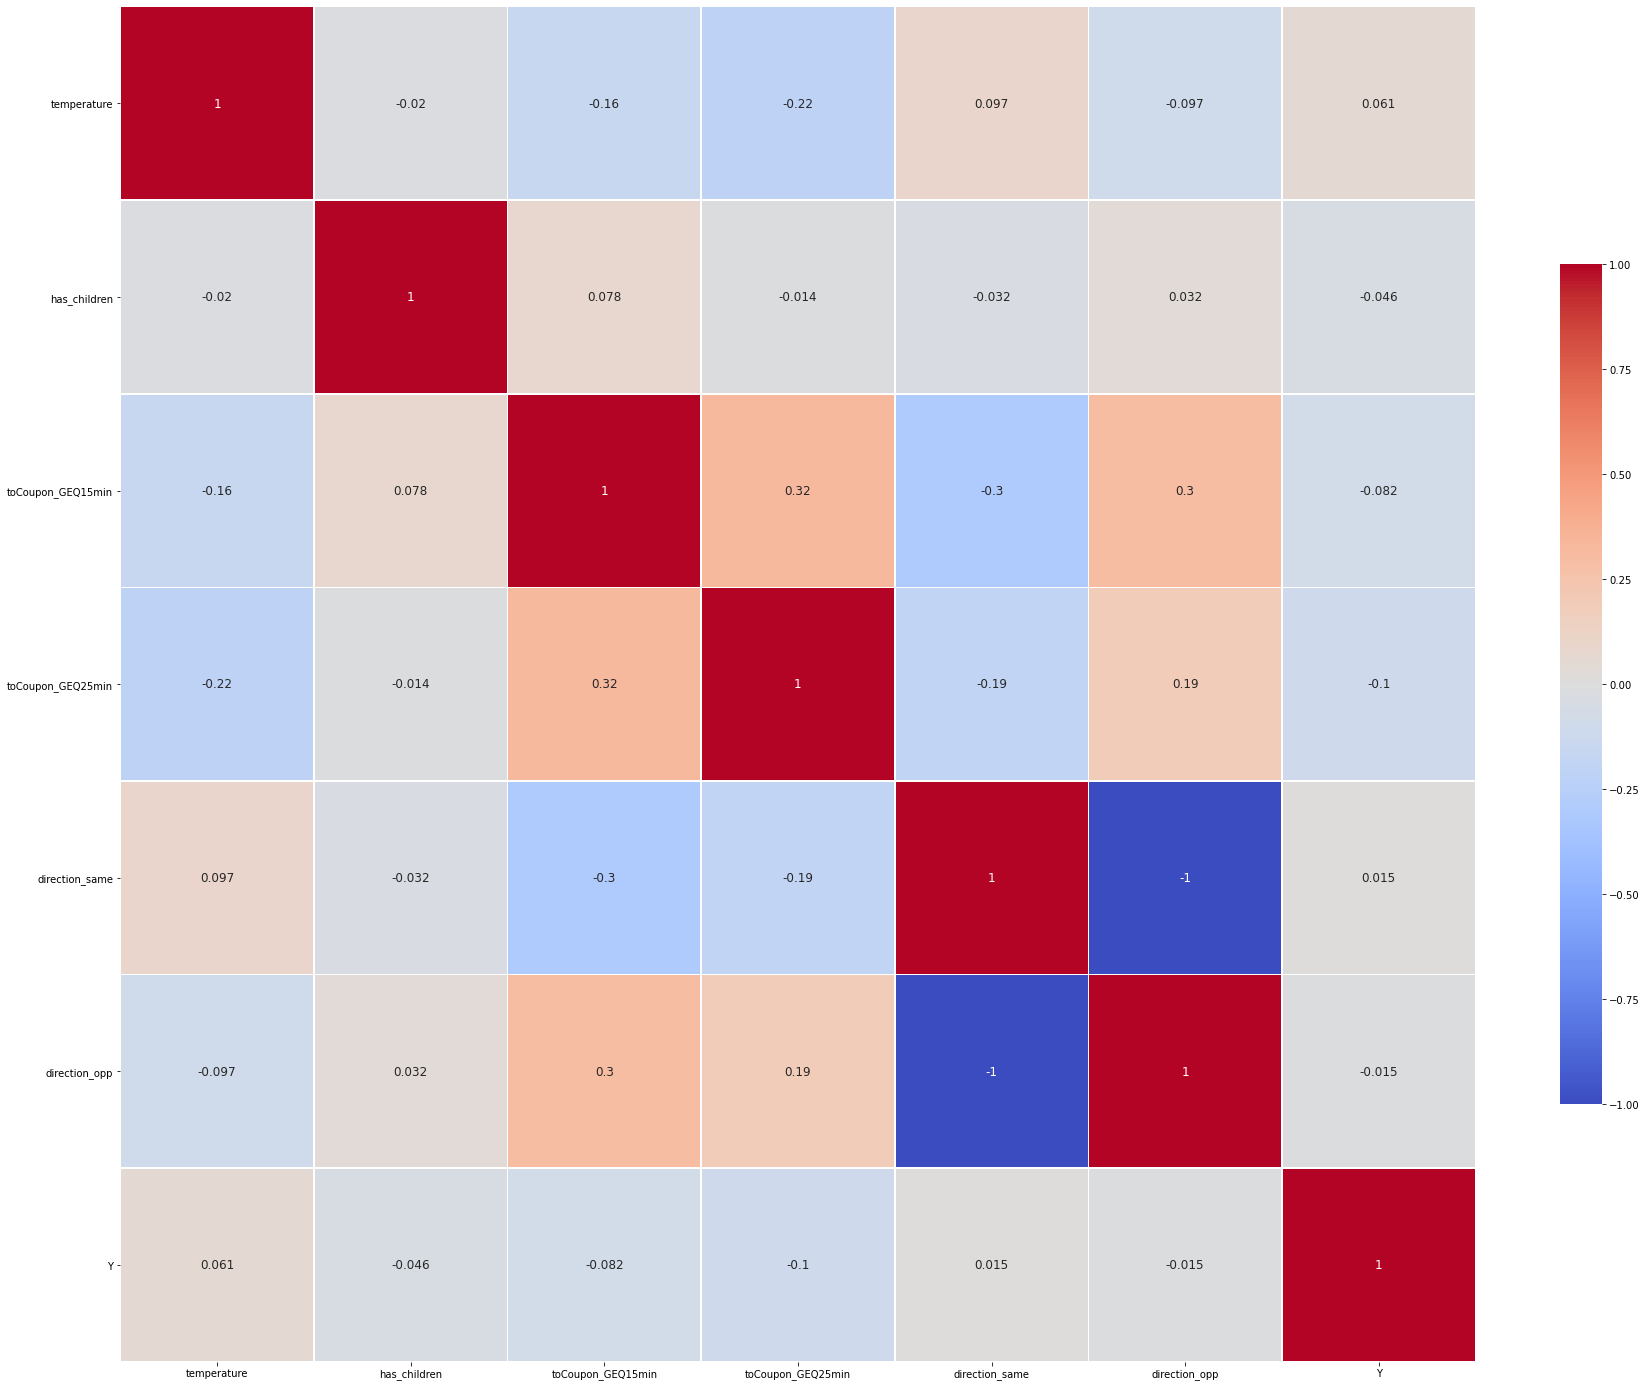

In [ ]:
# Checking the correlation between features.
mask_raw = np.zeros_like(df_raw.corr(), dtype=np.bool)

fig, axis = plt.subplots(figsize=(25,20))

heatmap_raw = sns_raw.heatmap(df_raw.corr(), 
                      mask = mask_raw,
                      cmap = 'coolwarm',
                      square = True,
                      linewidths = .6,
                      cbar_kws = {'shrink': .6, 
                                'ticks' : [-1, -.75,-.5,-.25, 0, .25, 0.5, 0.75, 1]},
                      vmax = 1,
                      annot = True,
                      annot_kws = {"size": 12})

axis.set_xticklabels(df_raw.corr().columns)
axis.set_yticklabels(df_raw.corr().columns, rotation = 0)


sns_raw.set_style({'xtick.bottom': True}, {'ytick.left': True})
plt.tight_layout()

In [ ]:
# direction_same and direction_opp are negatively correlated, hence keeping only one of them is sufficient for classification.
#df_raw = df_raw.drop('direction_opp', axis=1)

In [ ]:
df_raw['Bar'].value_counts()

never    5197
less1    3482
1~3      2473
4~8      1076
gt8       349
Name: Bar, dtype: int64

In [ ]:
# Imputing missing value with maximum occuring value 'never'
df_raw['Bar'].replace(np.NaN, 'never', inplace = True)

In [ ]:
df_raw['CoffeeHouse'].value_counts()      

less1    3385
1~3      3225
never    2962
4~8      1784
gt8      1111
Name: CoffeeHouse, dtype: int64

In [ ]:
# Imputing missing value with maximum occuring value 'less1'
df_raw['CoffeeHouse'].replace(np.NaN, 'less1', inplace = True)

In [ ]:
df_raw['CarryAway'].value_counts()

1~3      4672
4~8      4258
less1    1856
gt8      1594
never     153
Name: CarryAway, dtype: int64

In [ ]:
# Imputing missing value with maximum occuring value '1~3'
df_raw['CarryAway'].replace(np.NaN, '1~3', inplace = True)

In [ ]:
df_raw['RestaurantLessThan20'].value_counts()

1~3      5376
4~8      3580
less1    2093
gt8      1285
never     220
Name: RestaurantLessThan20, dtype: int64

In [ ]:
# Imputing missing value with maximum occuring value '1~3'
df_raw['RestaurantLessThan20'].replace(np.NaN, '1~3', inplace = True)

In [ ]:
df_raw['Restaurant20To50'].value_counts()

less1    6077
1~3      3290
never    2136
4~8       728
gt8       264
Name: Restaurant20To50, dtype: int64

In [ ]:
# Imputing missing value with maximum occuring value 'less1'
df_raw['Restaurant20To50'].replace(np.NaN, 'less1', inplace = True)

In [ ]:
df_raw.isna().sum()

destination             0
passanger               0
weather                 0
temperature             0
time                    0
coupon                  0
expiration              0
gender                  0
age                     0
maritalStatus           0
has_children            0
education               0
occupation              0
income                  0
Bar                     0
CoffeeHouse             0
CarryAway               0
RestaurantLessThan20    0
Restaurant20To50        0
toCoupon_GEQ15min       0
toCoupon_GEQ25min       0
direction_same          0
direction_opp           0
Y                       0
dtype: int64

In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  Bar                   12684 non-null  object
 15  CoffeeHouse           12684 non-null

*Categorical columns present are :- destination, passenger, weather, time, coupon, expiration, gender, age, maritalstatus, education, occupation, income, Bar, CoffeeHouse, CarryAway, RestaurantLessThan20, Restaurant20To50.*

*Applying one hot encoding on categorical columns.*

In [ ]:
cols_cat = pd.get_dummies(df_raw['destination'], prefix = 'dest')
df_raw[cols_cat.columns] = cols_cat
df_raw = df_raw.drop(['destination'], axis = 1)
df_raw.columns

Index(['passanger', 'weather', 'temperature', 'time', 'coupon', 'expiration',
       'gender', 'age', 'maritalStatus', 'has_children', 'education',
       'occupation', 'income', 'Bar', 'CoffeeHouse', 'CarryAway',
       'RestaurantLessThan20', 'Restaurant20To50', 'toCoupon_GEQ15min',
       'toCoupon_GEQ25min', 'direction_same', 'direction_opp', 'Y',
       'dest_Home', 'dest_No Urgent Place', 'dest_Work'],
      dtype='object')

In [ ]:
cols_cat = pd.get_dummies(df_raw['weather'], prefix = 'weath')
df_raw[cols_cat.columns] = cols_cat
df_raw = df_raw.drop(['weather'], axis = 1)
df_raw.columns

Index(['passanger', 'temperature', 'time', 'coupon', 'expiration', 'gender',
       'age', 'maritalStatus', 'has_children', 'education', 'occupation',
       'income', 'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20',
       'Restaurant20To50', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min',
       'direction_same', 'direction_opp', 'Y', 'dest_Home',
       'dest_No Urgent Place', 'dest_Work', 'weath_Rainy', 'weath_Snowy',
       'weath_Sunny'],
      dtype='object')

In [ ]:
cols_cat = pd.get_dummies(df_raw['passanger'], prefix = 'pass')
df_raw[cols_cat.columns] = cols_cat
df_raw = df_raw.drop(['passanger'], axis = 1)
df_raw.columns

Index(['temperature', 'time', 'coupon', 'expiration', 'gender', 'age',
       'maritalStatus', 'has_children', 'education', 'occupation', 'income',
       'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20',
       'Restaurant20To50', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min',
       'direction_same', 'direction_opp', 'Y', 'dest_Home',
       'dest_No Urgent Place', 'dest_Work', 'weath_Rainy', 'weath_Snowy',
       'weath_Sunny', 'pass_Alone', 'pass_Friend(s)', 'pass_Kid(s)',
       'pass_Partner'],
      dtype='object')

In [ ]:
cols_cat = pd.get_dummies(df_raw['time'], prefix = 'time')
df_raw[cols_cat.columns] = cols_cat
df_raw = df_raw.drop(['time'], axis = 1)
df_raw.columns

Index(['temperature', 'coupon', 'expiration', 'gender', 'age', 'maritalStatus',
       'has_children', 'education', 'occupation', 'income', 'Bar',
       'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50',
       'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 'direction_same',
       'direction_opp', 'Y', 'dest_Home', 'dest_No Urgent Place', 'dest_Work',
       'weath_Rainy', 'weath_Snowy', 'weath_Sunny', 'pass_Alone',
       'pass_Friend(s)', 'pass_Kid(s)', 'pass_Partner', 'time_10AM',
       'time_10PM', 'time_2PM', 'time_6PM', 'time_7AM'],
      dtype='object')

In [ ]:
cols_cat = pd.get_dummies(df_raw['coupon'], prefix = 'coup')
df_raw[cols_cat.columns] = cols_cat
df_raw = df_raw.drop(['coupon'], axis = 1)
df_raw.columns

Index(['temperature', 'expiration', 'gender', 'age', 'maritalStatus',
       'has_children', 'education', 'occupation', 'income', 'Bar',
       'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50',
       'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 'direction_same',
       'direction_opp', 'Y', 'dest_Home', 'dest_No Urgent Place', 'dest_Work',
       'weath_Rainy', 'weath_Snowy', 'weath_Sunny', 'pass_Alone',
       'pass_Friend(s)', 'pass_Kid(s)', 'pass_Partner', 'time_10AM',
       'time_10PM', 'time_2PM', 'time_6PM', 'time_7AM', 'coup_Bar',
       'coup_Carry out & Take away', 'coup_Coffee House',
       'coup_Restaurant(20-50)', 'coup_Restaurant(<20)'],
      dtype='object')

In [ ]:
# Gender feature - replace Female as 0 and Male as 1.
df_raw['gender'].replace("Female", 0, inplace = True)
df_raw['gender'].replace("Male", 1, inplace = True)

In [ ]:
# Expiration feature - replace 1d as 1 and 2h as 0.
df_raw['expiration'].replace("1d", 1, inplace = True)
df_raw['expiration'].replace("2h", 0, inplace = True)

Applying One hot encoding for catregorical features.

In [ ]:
cols_cat = pd.get_dummies(df_raw['age'], prefix = 'age')
df_raw[cols_cat.columns] = cols_cat
df_raw = df_raw.drop(['age'], axis = 1)
df_raw.columns

Index(['temperature', 'expiration', 'gender', 'maritalStatus', 'has_children',
       'education', 'occupation', 'income', 'Bar', 'CoffeeHouse', 'CarryAway',
       'RestaurantLessThan20', 'Restaurant20To50', 'toCoupon_GEQ15min',
       'toCoupon_GEQ25min', 'direction_same', 'direction_opp', 'Y',
       'dest_Home', 'dest_No Urgent Place', 'dest_Work', 'weath_Rainy',
       'weath_Snowy', 'weath_Sunny', 'pass_Alone', 'pass_Friend(s)',
       'pass_Kid(s)', 'pass_Partner', 'time_10AM', 'time_10PM', 'time_2PM',
       'time_6PM', 'time_7AM', 'coup_Bar', 'coup_Carry out & Take away',
       'coup_Coffee House', 'coup_Restaurant(20-50)', 'coup_Restaurant(<20)',
       'age_21', 'age_26', 'age_31', 'age_36', 'age_41', 'age_46',
       'age_50plus', 'age_below21'],
      dtype='object')

In [ ]:
cols_cat = pd.get_dummies(df_raw['maritalStatus'], prefix = 'mari_Stat')
df_raw[cols_cat.columns] = cols_cat
df_raw = df_raw.drop(['maritalStatus'], axis = 1)
df_raw.columns

Index(['temperature', 'expiration', 'gender', 'has_children', 'education',
       'occupation', 'income', 'Bar', 'CoffeeHouse', 'CarryAway',
       'RestaurantLessThan20', 'Restaurant20To50', 'toCoupon_GEQ15min',
       'toCoupon_GEQ25min', 'direction_same', 'direction_opp', 'Y',
       'dest_Home', 'dest_No Urgent Place', 'dest_Work', 'weath_Rainy',
       'weath_Snowy', 'weath_Sunny', 'pass_Alone', 'pass_Friend(s)',
       'pass_Kid(s)', 'pass_Partner', 'time_10AM', 'time_10PM', 'time_2PM',
       'time_6PM', 'time_7AM', 'coup_Bar', 'coup_Carry out & Take away',
       'coup_Coffee House', 'coup_Restaurant(20-50)', 'coup_Restaurant(<20)',
       'age_21', 'age_26', 'age_31', 'age_36', 'age_41', 'age_46',
       'age_50plus', 'age_below21', 'mari_Stat_Divorced',
       'mari_Stat_Married partner', 'mari_Stat_Single',
       'mari_Stat_Unmarried partner', 'mari_Stat_Widowed'],
      dtype='object')

In [ ]:
cols_cat = pd.get_dummies(df_raw['education'], prefix = 'ed')
df_raw[cols_cat.columns] = cols_cat
df_raw = df_raw.drop(['education'], axis = 1)
df_raw.columns

Index(['temperature', 'expiration', 'gender', 'has_children', 'occupation',
       'income', 'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20',
       'Restaurant20To50', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min',
       'direction_same', 'direction_opp', 'Y', 'dest_Home',
       'dest_No Urgent Place', 'dest_Work', 'weath_Rainy', 'weath_Snowy',
       'weath_Sunny', 'pass_Alone', 'pass_Friend(s)', 'pass_Kid(s)',
       'pass_Partner', 'time_10AM', 'time_10PM', 'time_2PM', 'time_6PM',
       'time_7AM', 'coup_Bar', 'coup_Carry out & Take away',
       'coup_Coffee House', 'coup_Restaurant(20-50)', 'coup_Restaurant(<20)',
       'age_21', 'age_26', 'age_31', 'age_36', 'age_41', 'age_46',
       'age_50plus', 'age_below21', 'mari_Stat_Divorced',
       'mari_Stat_Married partner', 'mari_Stat_Single',
       'mari_Stat_Unmarried partner', 'mari_Stat_Widowed',
       'ed_Associates degree', 'ed_Bachelors degree',
       'ed_Graduate degree (Masters or Doctorate)', 'ed_High School Gr

In [ ]:
cols_cat = pd.get_dummies(df_raw['income'], prefix = 'income')
df_raw[cols_cat.columns] = cols_cat
df_raw = df_raw.drop(['income'], axis = 1)
df_raw.columns

Index(['temperature', 'expiration', 'gender', 'has_children', 'occupation',
       'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20',
       'Restaurant20To50', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min',
       'direction_same', 'direction_opp', 'Y', 'dest_Home',
       'dest_No Urgent Place', 'dest_Work', 'weath_Rainy', 'weath_Snowy',
       'weath_Sunny', 'pass_Alone', 'pass_Friend(s)', 'pass_Kid(s)',
       'pass_Partner', 'time_10AM', 'time_10PM', 'time_2PM', 'time_6PM',
       'time_7AM', 'coup_Bar', 'coup_Carry out & Take away',
       'coup_Coffee House', 'coup_Restaurant(20-50)', 'coup_Restaurant(<20)',
       'age_21', 'age_26', 'age_31', 'age_36', 'age_41', 'age_46',
       'age_50plus', 'age_below21', 'mari_Stat_Divorced',
       'mari_Stat_Married partner', 'mari_Stat_Single',
       'mari_Stat_Unmarried partner', 'mari_Stat_Widowed',
       'ed_Associates degree', 'ed_Bachelors degree',
       'ed_Graduate degree (Masters or Doctorate)', 'ed_High School Graduate',
 

In [ ]:
cols_cat = pd.get_dummies(df_raw['Bar'], prefix = 'Bar')
df_raw[cols_cat.columns] = cols_cat
df_raw = df_raw.drop(['Bar'], axis = 1)
df_raw.columns

Index(['temperature', 'expiration', 'gender', 'has_children', 'occupation',
       'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50',
       'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 'direction_same',
       'direction_opp', 'Y', 'dest_Home', 'dest_No Urgent Place', 'dest_Work',
       'weath_Rainy', 'weath_Snowy', 'weath_Sunny', 'pass_Alone',
       'pass_Friend(s)', 'pass_Kid(s)', 'pass_Partner', 'time_10AM',
       'time_10PM', 'time_2PM', 'time_6PM', 'time_7AM', 'coup_Bar',
       'coup_Carry out & Take away', 'coup_Coffee House',
       'coup_Restaurant(20-50)', 'coup_Restaurant(<20)', 'age_21', 'age_26',
       'age_31', 'age_36', 'age_41', 'age_46', 'age_50plus', 'age_below21',
       'mari_Stat_Divorced', 'mari_Stat_Married partner', 'mari_Stat_Single',
       'mari_Stat_Unmarried partner', 'mari_Stat_Widowed',
       'ed_Associates degree', 'ed_Bachelors degree',
       'ed_Graduate degree (Masters or Doctorate)', 'ed_High School Graduate',
       'ed_Some

In [ ]:
cols_cat = pd.get_dummies(df_raw['CoffeeHouse'], prefix = 'Coffee')
df_raw[cols_cat.columns] = cols_cat
df_raw = df_raw.drop(['CoffeeHouse'], axis = 1)
df_raw.columns

Index(['temperature', 'expiration', 'gender', 'has_children', 'occupation',
       'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50',
       'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 'direction_same',
       'direction_opp', 'Y', 'dest_Home', 'dest_No Urgent Place', 'dest_Work',
       'weath_Rainy', 'weath_Snowy', 'weath_Sunny', 'pass_Alone',
       'pass_Friend(s)', 'pass_Kid(s)', 'pass_Partner', 'time_10AM',
       'time_10PM', 'time_2PM', 'time_6PM', 'time_7AM', 'coup_Bar',
       'coup_Carry out & Take away', 'coup_Coffee House',
       'coup_Restaurant(20-50)', 'coup_Restaurant(<20)', 'age_21', 'age_26',
       'age_31', 'age_36', 'age_41', 'age_46', 'age_50plus', 'age_below21',
       'mari_Stat_Divorced', 'mari_Stat_Married partner', 'mari_Stat_Single',
       'mari_Stat_Unmarried partner', 'mari_Stat_Widowed',
       'ed_Associates degree', 'ed_Bachelors degree',
       'ed_Graduate degree (Masters or Doctorate)', 'ed_High School Graduate',
       'ed_Some High School', 

In [ ]:
cols_cat = pd.get_dummies(df_raw['CarryAway'], prefix = 'Carry')
df_raw[cols_cat.columns] = cols_cat
df_raw = df_raw.drop(['CarryAway'], axis = 1)
df_raw.columns

Index(['temperature', 'expiration', 'gender', 'has_children', 'occupation',
       'RestaurantLessThan20', 'Restaurant20To50', 'toCoupon_GEQ15min',
       'toCoupon_GEQ25min', 'direction_same', 'direction_opp', 'Y',
       'dest_Home', 'dest_No Urgent Place', 'dest_Work', 'weath_Rainy',
       'weath_Snowy', 'weath_Sunny', 'pass_Alone', 'pass_Friend(s)',
       'pass_Kid(s)', 'pass_Partner', 'time_10AM', 'time_10PM', 'time_2PM',
       'time_6PM', 'time_7AM', 'coup_Bar', 'coup_Carry out & Take away',
       'coup_Coffee House', 'coup_Restaurant(20-50)', 'coup_Restaurant(<20)',
       'age_21', 'age_26', 'age_31', 'age_36', 'age_41', 'age_46',
       'age_50plus', 'age_below21', 'mari_Stat_Divorced',
       'mari_Stat_Married partner', 'mari_Stat_Single',
       'mari_Stat_Unmarried partner', 'mari_Stat_Widowed',
       'ed_Associates degree', 'ed_Bachelors degree',
       'ed_Graduate degree (Masters or Doctorate)', 'ed_High School Graduate',
       'ed_Some High School', 'ed_Some coll

In [ ]:
cols_cat = pd.get_dummies(df_raw['RestaurantLessThan20'], prefix = 'Restaurant_20')
df_raw[cols_cat.columns] = cols_cat
df_raw = df_raw.drop(['RestaurantLessThan20'], axis = 1)
df_raw.columns

Index(['temperature', 'expiration', 'gender', 'has_children', 'occupation',
       'Restaurant20To50', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min',
       'direction_same', 'direction_opp', 'Y', 'dest_Home',
       'dest_No Urgent Place', 'dest_Work', 'weath_Rainy', 'weath_Snowy',
       'weath_Sunny', 'pass_Alone', 'pass_Friend(s)', 'pass_Kid(s)',
       'pass_Partner', 'time_10AM', 'time_10PM', 'time_2PM', 'time_6PM',
       'time_7AM', 'coup_Bar', 'coup_Carry out & Take away',
       'coup_Coffee House', 'coup_Restaurant(20-50)', 'coup_Restaurant(<20)',
       'age_21', 'age_26', 'age_31', 'age_36', 'age_41', 'age_46',
       'age_50plus', 'age_below21', 'mari_Stat_Divorced',
       'mari_Stat_Married partner', 'mari_Stat_Single',
       'mari_Stat_Unmarried partner', 'mari_Stat_Widowed',
       'ed_Associates degree', 'ed_Bachelors degree',
       'ed_Graduate degree (Masters or Doctorate)', 'ed_High School Graduate',
       'ed_Some High School', 'ed_Some college - no degree',
      

In [ ]:
cols_cat = pd.get_dummies(df_raw['Restaurant20To50'], prefix = 'Restaurant20_50')
df_raw[cols_cat.columns] = cols_cat
df_raw = df_raw.drop(['Restaurant20To50'], axis = 1)
df_raw.columns

Index(['temperature', 'expiration', 'gender', 'has_children', 'occupation',
       'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 'direction_same',
       'direction_opp', 'Y', 'dest_Home', 'dest_No Urgent Place', 'dest_Work',
       'weath_Rainy', 'weath_Snowy', 'weath_Sunny', 'pass_Alone',
       'pass_Friend(s)', 'pass_Kid(s)', 'pass_Partner', 'time_10AM',
       'time_10PM', 'time_2PM', 'time_6PM', 'time_7AM', 'coup_Bar',
       'coup_Carry out & Take away', 'coup_Coffee House',
       'coup_Restaurant(20-50)', 'coup_Restaurant(<20)', 'age_21', 'age_26',
       'age_31', 'age_36', 'age_41', 'age_46', 'age_50plus', 'age_below21',
       'mari_Stat_Divorced', 'mari_Stat_Married partner', 'mari_Stat_Single',
       'mari_Stat_Unmarried partner', 'mari_Stat_Widowed',
       'ed_Associates degree', 'ed_Bachelors degree',
       'ed_Graduate degree (Masters or Doctorate)', 'ed_High School Graduate',
       'ed_Some High School', 'ed_Some college - no degree',
       'income_$100000 or More', 

In [ ]:
cols_cat = pd.get_dummies(df_raw['occupation'], prefix = 'occupa')
df_raw[cols_cat.columns] = cols_cat
df_raw = df_raw.drop(['occupation'], axis = 1)
df_raw.columns

Index(['temperature', 'expiration', 'gender', 'has_children',
       'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 'direction_same',
       'direction_opp', 'Y', 'dest_Home',
       ...
       'occupa_Management', 'occupa_Office & Administrative Support',
       'occupa_Personal Care & Service', 'occupa_Production Occupations',
       'occupa_Protective Service', 'occupa_Retired', 'occupa_Sales & Related',
       'occupa_Student', 'occupa_Transportation & Material Moving',
       'occupa_Unemployed'],
      dtype='object', length=107)

In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Columns: 107 entries, temperature to occupa_Unemployed
dtypes: int64(9), uint8(98)
memory usage: 2.1 MB


In [ ]:
df_raw.head()

,temperature,expiration,gender,has_children,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y,dest_Home,...,occupa_Management,occupa_Office & Administrative Support,occupa_Personal Care & Service,occupa_Production Occupations,occupa_Protective Service,occupa_Retired,occupa_Sales & Related,occupa_Student,occupa_Transportation & Material Moving,occupa_Unemployed
0,55,1,0,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
1,80,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,80,0,0,1,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
3,80,0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,80,1,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
df_final = df_raw

In [ ]:
df_final.head()

,temperature,expiration,gender,has_children,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y,dest_Home,...,occupa_Management,occupa_Office & Administrative Support,occupa_Personal Care & Service,occupa_Production Occupations,occupa_Protective Service,occupa_Retired,occupa_Sales & Related,occupa_Student,occupa_Transportation & Material Moving,occupa_Unemployed
0,55,1,0,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
1,80,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,80,0,0,1,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
3,80,0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,80,1,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
# Splitting features and target variables from dataframe.
y = df_final['Y']
X = df_final.drop(['Y'], axis = 1)

In [ ]:
y.value_counts()

1    7210
0    5474
Name: Y, dtype: int64

In [ ]:
# Train and Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
# Applying scaling on feature variables
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
#Random Forest Classifier model with Train and Test split 
clf_base = RandomForestClassifier()

#Training the model
clf_base.fit(X_train,y_train)

RandomForestClassifier()

In [ ]:
y_pred = clf_base.predict(X_test)
#y_pred = cross_val_predict(clf_base, X_test, y_test, cv=cross_val_st) 

In [ ]:
# Random Forest baseline model accuracy
print("RF Base line model accuracy:", metrics.accuracy_score(y_test, y_pred)*100)

RF Base line model accuracy: 74.85218762317697


In [ ]:
# Random Forest baseline classification report
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.65      0.70      1128
           1       0.75      0.83      0.79      1409

    accuracy                           0.75      2537
   macro avg       0.75      0.74      0.74      2537
weighted avg       0.75      0.75      0.75      2537



In [ ]:
#Random Forest base line model - Mean and Std deviation with stratified cross validation.
cross_val = StratifiedKFold(n_splits=10)

X_s, y_s = shuffle(X, y)
rf_cv_scores = cross_val_score(clf_base, X_s, y_s, cv = cross_val)

print("Accuracy from each of 10 folds: ", rf_cv_scores)
print("%0.2f Mean accuracy for Random Forest base model with a standard deviation of %0.2f" % (rf_cv_scores.mean(), rf_cv_scores.std()))

Accuracy from each of 10 folds:  [0.76595745 0.76201734 0.75019701 0.75098503 0.77681388 0.76104101
 0.7681388  0.75315457 0.77760252 0.76735016]
0.76 Mean accuracy for Random Forest base model with a standard deviation of 0.01


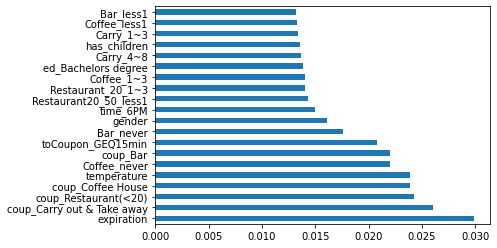

In [ ]:
# Feature importance before hyper parameter tunning
feat_importance = clf_base.feature_importances_

feat_importances_pre_hyper = pd.Series(feat_importance, index = X.columns)
feat_importances_pre_hyper.nlargest(20).plot(kind='barh')

Random Forest Classification for with hyper parameter set 1:

In [ ]:
# Iteration 1: Perform 10 fold grid search to tune hyperparameter of the random forest model.
cross_val = StratifiedKFold(n_splits=10)
#index_iterator = cross_val.split(X_train, y_train)

clf_random = RandomForestClassifier()

params_1 = { 
    'n_estimators': [10, 50, 100],
    'max_features': ['auto','sqrt','log2'],
    'max_depth' : list(range(1, 8)),
    'criterion' :['entropy', 'gini'] 
}

clf_rf = GridSearchCV(clf_random, params_1, cv = cross_val, verbose=0)

#rf_model = clf_rf.fit(X,y)

clf_rf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [10, 50, 100]})

In [ ]:
clf_rf.best_params_

{'criterion': 'entropy',
 'max_depth': 7,
 'max_features': 'sqrt',
 'n_estimators': 100}

In [ ]:
# Investigate the per fold accuracy, mean accuracy with deviation  for Random Forest Classifier model iteration 1 of hyper parameter tunning 
rfc_hyper_param_1 = RandomForestClassifier(max_depth=7, n_estimators=100, max_features='sqrt', criterion = 'entropy')
cross_val = StratifiedKFold(n_splits=10)

X_s, y_s = shuffle(X, y)
cv_results_rf_hyp_1 = cross_val_score(rfc_hyper_param_1, X_s, y_s, cv = cross_val, scoring='accuracy')

print("Random Forest Model Hyper Param 1 accuracy from each of 10 folds: ", cv_results_rf_hyp_1)
print("Random Forest Model Hyper Param 1 Mean Accuracy: %.3f%%, Random Forest Model Hyper Param 1 Standard Deviation: (%.3f%%)" % (cv_results_rf_hyp_1.mean()*100.0, cv_results_rf_hyp_1.std()*100.0))

Random Forest Model Hyper Param 1 accuracy from each of 10 folds:  [0.7178881  0.73049645 0.73680063 0.71000788 0.70583596 0.69400631
 0.71214511 0.72160883 0.71845426 0.71451104]
Random Forest Model Hyper Param 1 Mean Accuracy: 71.618%, Random Forest Model Hyper Param 1 Standard Deviation: (1.150%)


In [ ]:
#Training the Random Forest Classifier model with Train and Test split in iteration 1 of hyper parameter tunning 
rfc_hyper_param_1.fit(X_train,y_train)

y_pred_hyp_1 = rfc_hyper_param_1.predict(X_test)

# Model Accuracy
print("Accuracy of Random Forest Classifier model with Train and Test split in iteration 1 of hyper parameter tunning:", metrics.accuracy_score(y_test, y_pred_hyp_1))

Accuracy of Random Forest Classifier model with Train and Test split in iteration 1 of hyper parameter tunning: 0.7047694126921561


In [ ]:
print("Classification report of Random Forest Classifier model with Train and Test split in iteration 1 of hyper parameter tunning:", metrics.classification_report(y_test, y_pred_hyp_1))

Classification report of Random Forest Classifier model with Train and Test split in iteration 1 of hyper parameter tunning:               precision    recall  f1-score   support

           0       0.74      0.51      0.61      1128
           1       0.69      0.86      0.76      1409

    accuracy                           0.70      2537
   macro avg       0.72      0.69      0.69      2537
weighted avg       0.71      0.70      0.69      2537



In [ ]:
# Iteration 2: Perform 10 fold grid search to tune hyperparameter of the random forest model.
cross_val = StratifiedKFold(n_splits=10)
#index_iterator = cross_val.split(X_train, y_train)

clf_random_2 = RandomForestClassifier()

params_2 = {
    'n_estimators': [50, 150, 300],
    'max_depth' : list(range(8, 16)),
    'min_samples_split' : [1, 3, 7],
    'bootstrap' : [True, False]
}

clf_rf_2 = GridSearchCV(clf_random_2, params_2, cv = cross_val, verbose=0)

#rf_model_2 = clf_rf_2.fit(X,y)

clf_rf_2.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [8, 9, 10, 11, 12, 13, 14, 15],
                         'min_samples_split': [1, 3, 7],
                         'n_estimators': [50, 150, 300]})

In [ ]:
print('Best Parameter RF Itr2:', clf_rf_2.best_params_)

Best Parameter RF Itr2: {'bootstrap': False, 'max_depth': 15, 'min_samples_split': 3, 'n_estimators': 300}


In [ ]:
rfc_hyper_param_2 = RandomForestClassifier(max_depth=15, n_estimators=300, bootstrap='false', min_samples_split = 3)
cross_val = StratifiedKFold(n_splits=10)

X_s, y_s = shuffle(X, y)
cv_results_rf_hyp_2 = cross_val_score(rfc_hyper_param_2, X_s, y_s, cv = cross_val, scoring='accuracy')

print("Random Forest Model Hyper Param 2 accuracy from each of 10 folds: ", cv_results_rf_hyp_2)
print("Random Forest Model Hyper Param 2 Mean Accuracy: %.3f%%, Random Forest Model Hyper Param 2 Standard Deviation: (%.3f%%)" % (cv_results_rf_hyp_2.mean()*100.0, cv_results_rf_hyp_2.std()*100.0))

Random Forest Model Hyper Param 2 accuracy from each of 10 folds:  [0.75886525 0.75492514 0.76910954 0.74783294 0.75394322 0.76182965
 0.74684543 0.75       0.77444795 0.75788644]
Random Forest Model Hyper Param 2 Mean Accuracy: 75.757%, Random Forest Model Hyper Param 2 Standard Deviation: (0.852%)


In [ ]:
#Training the Random Forest Classifier model with Train and Test split in iteration 2 of hyper parameter tunning 
rfc_hyper_param_2.fit(X_train,y_train)

y_pred_hyp_2 = rfc_hyper_param_2.predict(X_test)

# Model Accuracy
print("Accuracy of Random Forest Classifier model with Train and Test split in iteration 2 of hyper parameter tunning:", metrics.accuracy_score(y_test, y_pred_hyp_2))

Accuracy of Random Forest Classifier model with Train and Test split in iteration 2 of hyper parameter tunning: 0.7437918801734332


In [ ]:
print("Classification report of Random Forest Classifier model with Train and Test split in iteration 2 of hyper parameter tunning:", metrics.classification_report(y_test, y_pred_hyp_2))

Classification report of Random Forest Classifier model with Train and Test split in iteration 2 of hyper parameter tunning:               precision    recall  f1-score   support

           0       0.76      0.61      0.68      1128
           1       0.73      0.85      0.79      1409

    accuracy                           0.74      2537
   macro avg       0.75      0.73      0.73      2537
weighted avg       0.75      0.74      0.74      2537



In [ ]:
# Iteration 3: Perform 10 fold grid search to tune hyperparameter of the random forest model.
cross_val = StratifiedKFold(n_splits=10)
#index_iterator = cross_val.split(X_train, y_train)

params_3 = {
    'n_estimators': [200, 500, 700],
    'max_depth' : list(range(15, 30)),
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [1, 3, 5],
    'random_state': [101]
}

clf_random_3 = RandomForestClassifier()

clf_rf_3 = GridSearchCV(clf_random_3, params_3, cv = cross_val, verbose=0)

#rf_model_3 = clf_rf_3.fit(X,y)

clf_rf_3.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'max_depth': [15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                       25, 26, 27, 28, 29],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 3, 5],
                         'n_estimators': [200, 500, 700],
                         'random_state': [101]})

In [ ]:
print('Best Parameter RF Itr3:', clf_rf_3.best_params_)

Best Parameter RF Itr3: {'max_depth': 23, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 700, 'random_state': 101}


In [ ]:
rfc_hyper_param_3 = RandomForestClassifier(max_depth=23, n_estimators=700, max_features='auto', min_samples_leaf = 1, random_state = 101)
cross_val = StratifiedKFold(n_splits=10)

X_s, y_s = shuffle(X, y)
cv_results_rf_hyp_3 = cross_val_score(rfc_hyper_param_3, X_s, y_s, cv = cross_val, scoring='accuracy')

print("Random Forest Model Hyper Param 3 accuracy from each of 10 folds: ", cv_results_rf_hyp_3)
print("Random Forest Model Hyper Param 3 Mean Accuracy: %.3f%%, Random Forest Model Hyper Param 3 Standard Deviation: (%.3f%%)" % (cv_results_rf_hyp_3.mean()*100.0, cv_results_rf_hyp_3.std()*100.0))

Random Forest Model Hyper Param 3 accuracy from each of 10 folds:  [0.78014184 0.76201734 0.76910954 0.75571316 0.76892744 0.76656151
 0.76577287 0.77287066 0.78233438 0.7681388 ]
Random Forest Model Hyper Param 3 Mean Accuracy: 76.916%, Random Forest Model Hyper Param 3 Standard Deviation: (0.748%)


In [ ]:
#Training the Random Forest Classifier model with Train and Test split in iteration 3 with hyper parameter tunning 
rfc_hyper_param_3.fit(X_train,y_train)

y_pred_hyp_3 = rfc_hyper_param_3.predict(X_test)

# Model Accuracy
print("Accuracy of Random Forest Classifier model with Train and Test split in iteration 3 of hyper parameter tunning:", metrics.accuracy_score(y_test, y_pred_hyp_3))

Accuracy of Random Forest Classifier model with Train and Test split in iteration 3 of hyper parameter tunning: 0.7532518722901064


In [ ]:
print("Classification report of Random Forest Classifier model with Train and Test split in iteration 3 of hyper parameter tunning:", metrics.classification_report(y_test, y_pred_hyp_3))

Classification report of Random Forest Classifier model with Train and Test split in iteration 3 of hyper parameter tunning:               precision    recall  f1-score   support

           0       0.77      0.64      0.70      1128
           1       0.75      0.84      0.79      1409

    accuracy                           0.75      2537
   macro avg       0.76      0.74      0.74      2537
weighted avg       0.75      0.75      0.75      2537



Feature importance post hyperparameter tunning of Random Forest Model:

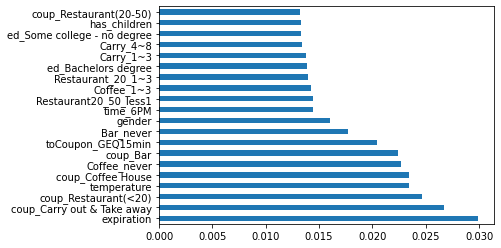

In [ ]:
# Feature importance before hyper parameter tunning
importance = rfc_hyper_param_3.feature_importances_

feat_importances_post_hyper = pd.Series(importance, index = X.columns)
feat_importances_post_hyper.nlargest(20).plot(kind='barh')

# SVM Classifier

In [ ]:
# train the model on train set
model_base_SVM = SVC()
model_base_SVM.fit(X_train, y_train)
 
# print prediction results
y_pred_base = model_base_SVM.predict(X_test)
print(classification_report(y_test, y_pred_base))

              precision    recall  f1-score   support

           0       0.75      0.64      0.69      1128
           1       0.74      0.83      0.78      1409

    accuracy                           0.74      2537
   macro avg       0.74      0.73      0.74      2537
weighted avg       0.74      0.74      0.74      2537



In [ ]:
test_accuracy_svm_base = accuracy_score(y_test,y_pred_base)*100

print("SVM accuracy for testing dataset without hyper parameter tuning is : {:.2f}%".format(test_accuracy_svm_base) )

SVM accuracy for testing dataset without hyper parameter tuning is : 74.42%


In [ ]:
#SVM model - Mean and Std deviation.
cross_val = StratifiedKFold(n_splits=10)
X_s, y_s = shuffle(X, y)
scores = cross_val_score(model_base_SVM, X_s, y_s, cv = cross_val, scoring='accuracy')

print("SVM Model accuracy from each of 10 folds: ", scores)
print("SVM Model Mean Accuracy: %.3f%%, SVM Model Standard Deviation: (%.3f%%)" % (scores.mean()*100.0, scores.std()*100.0))

SVM Model accuracy from each of 10 folds:  [0.57525611 0.57604413 0.57683215 0.57210402 0.57413249 0.58044164
 0.579653   0.57492114 0.57097792 0.57176656]
SVM Model Mean Accuracy: 57.521%, SVM Model Standard Deviation: (0.302%)


In [ ]:
# defining parameter range
param_grid_svm = {'C': [0.1, 10, 100],
              'gamma': [1, 0.1, 0.01],
              'kernel': ['rbf', 'poly', 'sigmoid']}

cross_val = StratifiedKFold(n_splits=10)
 
grid_svm = GridSearchCV(model_base_SVM, param_grid_svm, verbose = 3, cv = cross_val)
 
# fitting the model for grid search
grid_svm.fit(X_train, y_train)

Fitting 10 folds for each of 27 candidates, totalling 270 fits
[CV 1/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.571 total time=  18.3s
[CV 2/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.571 total time=  18.9s
[CV 3/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.571 total time=  18.1s
[CV 4/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.571 total time=  18.0s
[CV 5/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.571 total time=  17.8s
[CV 6/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.571 total time=  18.0s
[CV 7/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.572 total time=  18.2s
[CV 8/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.572 total time=  18.5s
[CV 9/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.572 total time=  18.2s
[CV 10/10] END ......C=0.1, gamma=1, kernel=rbf;, score=0.572 total time=  18.0s
[CV 1/10] END ......C=0.1, gamma=1, kernel=poly;, score=0.748 total time=  16.8s
[CV 2/10] END ......C=0.1, gamma=1, kernel=pol

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=SVC(),
             param_grid={'C': [0.1, 10, 100], 'gamma': [1, 0.1, 0.01],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             verbose=3)

In [ ]:
# print best parameter after tuning
print(grid_svm.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid_svm.best_estimator_)

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=100, gamma=0.01)


In [ ]:
svm_clf_hyper_param = SVC(C=100, gamma=0.01, kernel='rbf')
cross_val = StratifiedKFold(n_splits=10)

X_s, y_s = shuffle(X, y)
cv_results_svm_hyp = cross_val_score(svm_clf_hyper_param, X_s, y_s, cv = cross_val, scoring='accuracy')

print("SVM Hyper Param Tuned Model accuracy from each of 10 folds: ", cv_results_svm_hyp)
print("SVM Hyper Param Tuned Model Mean Accuracy: %.3f%%, SVM Hyper Param Tuned Model Standard Deviation: (%.3f%%)" % (cv_results_svm_hyp.mean()*100.0, cv_results_svm_hyp.std()*100.0))


SVM Hyper Param Tuned Model accuracy from each of 10 folds:  [0.77068558 0.75886525 0.76359338 0.77304965 0.74369085 0.75709779
 0.7555205  0.76498423 0.74684543 0.76892744]
SVM Hyper Param Tuned Model Mean Accuracy: 76.033%, SVM Hyper Param Tuned Model Standard Deviation: (0.933%)


In [ ]:
#Training the SVM model with Train and Test split and hyper parameter tunning 
svm_clf_hyper_param.fit(X_train,y_train)

y_pred_svm_hyp = svm_clf_hyper_param.predict(X_test)

# Model Accuracy
print("Accuracy of SVM model with Train and Test split and hyper parameter tunning:", metrics.accuracy_score(y_test, y_pred_svm_hyp))

Accuracy of SVM model with Train and Test split and hyper parameter tunning: 0.7414268821442649


In [ ]:
print("Classification report of SVM Classifier model with Train and Test split and hyper parameter tunning:", metrics.classification_report(y_test, y_pred_svm_hyp))

Classification report of SVM Classifier model with Train and Test split and hyper parameter tunning:               precision    recall  f1-score   support

           0       0.73      0.66      0.69      1128
           1       0.75      0.80      0.78      1409

    accuracy                           0.74      2537
   macro avg       0.74      0.73      0.74      2537
weighted avg       0.74      0.74      0.74      2537



In [ ]:
# grid_predictions = grid_svm.predict(X_test)
 
# # print classification report
# print(classification_report(y_test, grid_predictions))

In [ ]:
test_accuracy_svm_grid = accuracy_score(y_test,y_pred_svm_hyp)*100

print("SVM accuracy Grid Search CV for testing dataset with hyper parameter tuning is : {:.2f}%".format(test_accuracy_svm_grid) )

SVM accuracy Grid Search CV for testing dataset with hyper parameter tuning is : 74.14%


# Logistic Regression Classifier

In [ ]:
lr_base_clf = LogisticRegression()

lr_base_clf.fit(X_train, y_train)

LogisticRegression()

In [ ]:
# make predictions for test data
y_pred_lr_base = lr_base_clf.predict(X_test)

# LR base model accuracy
print("LR base model accuracy:", metrics.accuracy_score(y_test, y_pred_lr_base)*100)

LR base model accuracy: 68.70319274733939


In [ ]:
# Logistic Regression base model classification report
print(classification_report(y_test, y_pred_lr_base))

              precision    recall  f1-score   support

           0       0.68      0.57      0.62      1128
           1       0.69      0.78      0.73      1409

    accuracy                           0.69      2537
   macro avg       0.68      0.68      0.68      2537
weighted avg       0.69      0.69      0.68      2537



In [ ]:
# LR base model - Mean and Std deviation with stratified cross validation.
cross_val = StratifiedKFold(n_splits=10)

X_s, y_s = shuffle(X, y)
lr_cv_scores = cross_val_score(lr_base_clf, X_s, y_s, cv = cross_val)

print("LR model accuracy from each of 10 folds: ", lr_cv_scores)
print("%0.2f Mean accuracy for LR base model with a standard deviation of %0.2f" % (lr_cv_scores.mean(), lr_cv_scores.std()))

LR model accuracy from each of 10 folds:  [0.67769898 0.66509062 0.6855792  0.69818755 0.68059937 0.71135647
 0.68217666 0.68533123 0.69085174 0.68769716]
0.69 Mean accuracy for LR base model with a standard deviation of 0.01


In [ ]:
# LR Model Grid Search CV with hyper parameters
lr_grid = LogisticRegression()
cross_val = StratifiedKFold(n_splits=10)

# defining parameter range
lr_grid_params = {
    'penalty' : ['l1', 'l2', 'elasticnet'],
    'solver' : ['lbfgs','newton-cg','liblinear'],
    'C' : np.logspace(-4, 4, 20),
    'max_iter' : [100, 1000, 2500]
    }

grid_lr_clf = GridSearchCV(lr_grid, lr_grid_params, cv=cross_val, scoring = 'accuracy')
  
# fitting the model for grid search
grid_lr_clf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'max_iter': [100, 1000, 2500],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['lbfgs', 'newton-cg', 'liblinear']},
             scoring='accuracy')

In [ ]:
# print best parameter after tuning
print(grid_lr_clf.best_params_)

# print model after hyper-parameter tuning
print(grid_lr_clf.best_estimator_)

{'C': 0.23357214690901212, 'max_iter': 2500, 'penalty': 'l1', 'solver': 'liblinear'}
LogisticRegression(C=0.23357214690901212, max_iter=2500, penalty='l1',
                   solver='liblinear')


In [ ]:
lr_best_params = LogisticRegression(C=0.23357214690901212, penalty='l1', solver='liblinear', max_iter=2500)
cross_val = StratifiedKFold(n_splits=10)

X_s, y_s = shuffle(X, y)
cv_results_lr_hyp = cross_val_score(lr_best_params, X_s, y_s, cv = cross_val, scoring='accuracy')

print("LR Hyper Param Tuned Model accuracy from each of 10 folds: ", cv_results_lr_hyp)
print("LR Hyper Param Tuned Model Mean Accuracy: %.3f%%, LR Hyper Param Tuned Model Standard Deviation: (%.3f%%)" % (cv_results_lr_hyp.mean()*100.0, cv_results_lr_hyp.std()*100.0))


LR Hyper Param Tuned Model accuracy from each of 10 folds:  [0.69739953 0.68400315 0.6855792  0.68479117 0.68690852 0.66719243
 0.67586751 0.69794953 0.69637224 0.70662461]
LR Hyper Param Tuned Model Mean Accuracy: 68.827%, LR Hyper Param Tuned Model Standard Deviation: (1.103%)


In [ ]:
#Training the SVM model with Train and Test split and hyper parameter tunning 
lr_best_params.fit(X_train,y_train)

y_pred_lr_hyp = lr_best_params.predict(X_test)

# Model Accuracy
print("Accuracy of LR model with Train and Test split and hyper parameter tunning:", metrics.accuracy_score(y_test, y_pred_lr_hyp))

Accuracy of LR model with Train and Test split and hyper parameter tunning: 0.689396925502562


In [ ]:
print("Classification report of LR Classifier model with Train and Test split and hyper parameter tunning:", metrics.classification_report(y_test, y_pred_lr_hyp))

Classification report of LR Classifier model with Train and Test split and hyper parameter tunning:               precision    recall  f1-score   support

           0       0.68      0.57      0.62      1128
           1       0.69      0.79      0.74      1409

    accuracy                           0.69      2537
   macro avg       0.69      0.68      0.68      2537
weighted avg       0.69      0.69      0.68      2537



In [ ]:
test_accuracy_lr_grid = accuracy_score(y_test,y_pred_lr_hyp)*100

print("LR model accuracy Grid Search CV for testing dataset with hyper parameter tuning is : {:.2f}%".format(test_accuracy_lr_grid) )

LR model accuracy Grid Search CV for testing dataset with hyper parameter tuning is : 68.94%
